[0]	train-rmse:47.34852+0.35007	test-rmse:48.08227+1.42369
[100]	train-rmse:6.05248+0.11284	test-rmse:27.02666+1.10785
[200]	train-rmse:1.67748+0.08880	test-rmse:26.27096+1.14486
[300]	train-rmse:0.52494+0.02483	test-rmse:26.18899+1.14834
[400]	train-rmse:0.21788+0.00639	test-rmse:26.17893+1.14726
[500]	train-rmse:0.11930+0.00197	test-rmse:26.17720+1.14760
[600]	train-rmse:0.08002+0.00132	test-rmse:26.17657+1.14758
[700]	train-rmse:0.06128+0.00093	test-rmse:26.17641+1.14758
[800]	train-rmse:0.05135+0.00066	test-rmse:26.17636+1.14757
[900]	train-rmse:0.04551+0.00066	test-rmse:26.17628+1.14757
[1000]	train-rmse:0.04175+0.00059	test-rmse:26.17626+1.14758
[1100]	train-rmse:0.03896+0.00046	test-rmse:26.17626+1.14758
[1111]	train-rmse:0.03872+0.00046	test-rmse:26.17626+1.14758
Resultados de la validación cruzada:
      train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0           47.348519        0.350069       48.082273       1.423686
1           45.110484        0.298291      

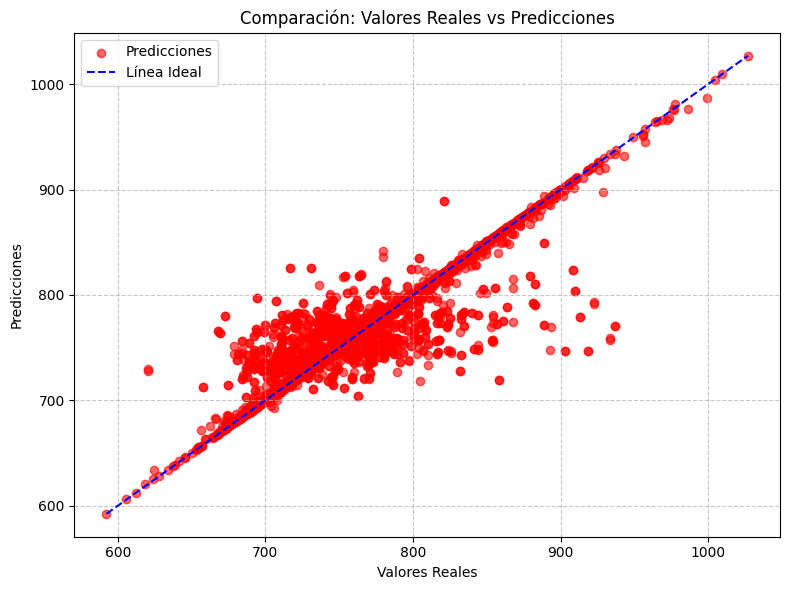

/home2/DSMaster/evarela/.local/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:25:01] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


['scalerXGBSD_6.pkl']

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost as xgb
import matplotlib.pyplot as plt
import joblib

# Cargar datos
dfFD = pd.read_csv("datosFD_num.csv", sep="\t")
dfSD = pd.read_csv("datosSD_num.csv", sep="\t")

# Combinar datos
fd_columns = ["FD_RS_fXmax", "FD_RS_fEnergy"]
sd_columns = dfSD.columns

combined_data = pd.merge(dfFD[fd_columns], dfSD[sd_columns], left_index=True, right_index=True)
combined_data.fillna(combined_data.median(), inplace=True)

# Filtrar datos en el rango de energía y calcular el logaritmo de la energía
data_filtered = combined_data[(combined_data["FD_RS_fEnergy"] >= 10**18.5) & (combined_data["FD_RS_fEnergy"] <= 10**20.0)].copy()
data_filtered["log_CalEnergy"] = np.log10(data_filtered["FD_RS_fEnergy"])

# Separar características y objetivo
X = data_filtered.drop(columns=["FD_RS_fXmax", "FD_RS_fEnergy"])
y = data_filtered["FD_RS_fXmax"]

# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Asignar pesos a las muestras en el rango de interés
sample_weights_train = np.where((y_train.index.map(data_filtered["log_CalEnergy"]) >= 19.5) & (y_train.index.map(data_filtered["log_CalEnergy"]) <= 20.0), 5, 1)
sample_weights_test = np.where((y_test.index.map(data_filtered["log_CalEnergy"]) >= 19.5) & (y_test.index.map(data_filtered["log_CalEnergy"]) <= 20.0), 5, 1)

# Convertir los datos a formato DMatrix para XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights_train)
dtest = xgb.DMatrix(X_test, label=y_test, weight=sample_weights_test)

# Ajustar hiperparámetros
params = {
    "objective": "reg:squarederror",  # Error cuadrático medio
    "eval_metric": "rmse",           # Métrica para evaluación
    "learning_rate": 0.1,          # Tasa de aprendizaje
    "max_depth": 10,                # Mayor profundidad
    "subsample": 0.9,               # Submuestreo de datos
    "colsample_bytree": 0.8,        # Submuestreo de características
    "reg_alpha": 0.5,               # Regularización L1
    "reg_lambda": 0,              # Regularización L2
    "seed": 42                      # Reproducibilidad
}

# Validación cruzada con XGBoost
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,           # Número máximo de iteraciones
    nfold=5,                        # Número de folds en la validación cruzada
    metrics="rmse",                 # Métrica a evaluar
    early_stopping_rounds=100,      # Detener si no mejora en 100 iteraciones
    seed=42,                        # Reproducibilidad
    as_pandas=True,                 # Devolver resultados en un DataFrame
    verbose_eval=100                # Mostrar progreso cada 100 iteraciones
)

# Mostrar resultados de la validación cruzada
print("Resultados de la validación cruzada:")
print(cv_results)

# Entrenar el modelo final con todos los datos de entrenamiento
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=cv_results.shape[0],  # Usar el mejor número de iteraciones
    evals=[(dtrain, "train"), (dtest, "test")],
    verbose_eval=100
)

# Predicciones
y_pred = xgb_model.predict(dtest)

# Evaluación del modelo
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Coeficiente de determinación (R²): {r2:.4f}")
print(f"Error cuadrático medio (MSE): {mse:.4f}")
print(f"Error absoluto medio (MAE): {mae:.4f}")
print(f"Raíz del error cuadrático medio (RMSE): {rmse:.4f}") 

# Comparación gráfica: Valores reales vs predicciones
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='red', alpha=0.6, label="Predicciones")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="blue", linestyle="--", label="Línea Ideal")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Comparación: Valores Reales vs Predicciones")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Guardar modelo (formato nativo de XGBoost)
xgb_model.save_model("xgbmSD_6.model")
joblib.dump(scaler, 'scalerXGBSD_6.pkl')

Coeficiente de determinación (R²): 0.8336


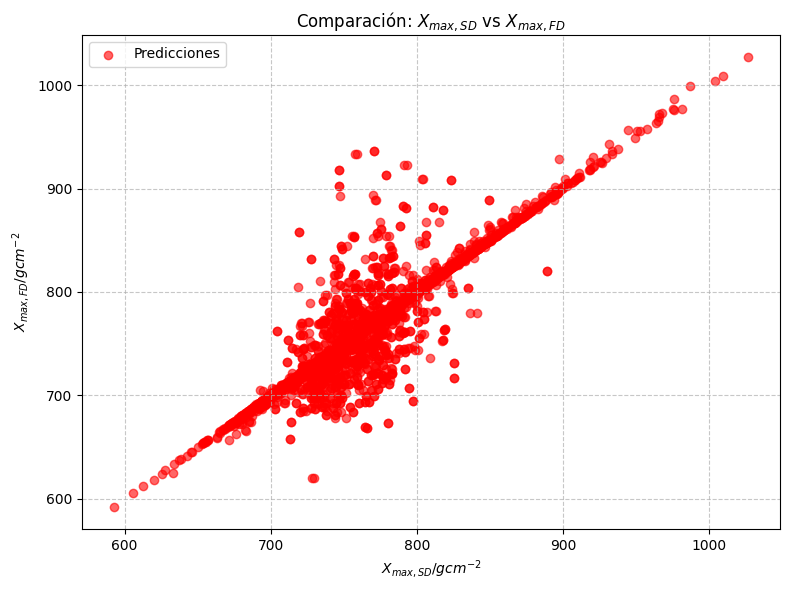

In [11]:
# Evaluación del modelo
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Coeficiente de determinación (R²): {r2:.4f}")
#print(f"Error cuadrático medio (MSE): {mse:.4f}")
#print(f"Error absoluto medio (MAE): {mae:.4f}")
#print(f"Raíz del error cuadrático medio (RMSE): {rmse:.4f}") 


plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test, color='red', alpha=0.6, label="Predicciones")
#plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="blue", linestyle="--", label="Línea Ideal")
plt.xlabel("$X_{max,SD}/g cm^{-2}$")
plt.ylabel("$X_{max,FD}/g cm^{-2}$")
plt.title("Comparación: $X_{max,SD}$ vs $X_{max,FD}$")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

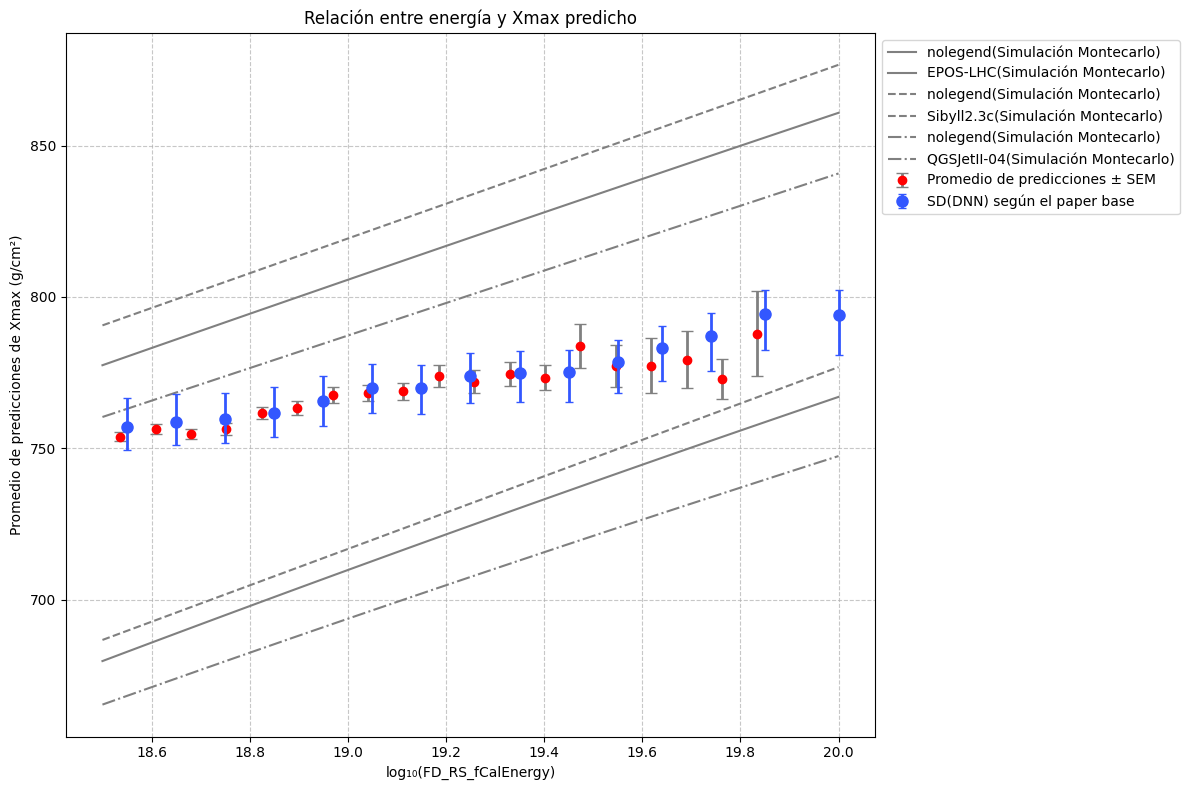

In [3]:
# Extraer log_CalEnergy para el conjunto de prueba
logE_test = data_filtered.loc[y_test.index, "log_CalEnergy"]

# Crear bins de energía
n_bins = 20
bins = np.linspace(logE_test.min(), logE_test.max(), n_bins + 1)
bin_centers = (bins[:-1] + bins[1:]) / 2  # Centros de los bins

# Calcular promedio, desviación estándar y número de muestras por bin de energía
avg_preds = []
std_preds = []
n_samples = []  # Número de muestras en cada bin

for i in range(len(bins) - 1):
    mask = (logE_test >= bins[i]) & (logE_test < bins[i+1])
    if np.any(mask):
        avg = np.mean(y_pred[mask])
        std = np.std(y_pred[mask])
        n = np.sum(mask)  # Número de muestras en el bin
    else:
        avg = np.nan
        std = np.nan
        n = 0
    avg_preds.append(avg)
    std_preds.append(std)
    n_samples.append(n)

avg_preds = np.array(avg_preds)
std_preds = np.array(std_preds)
n_samples = np.array(n_samples)

# Calcular el error estándar de la media (SEM)
sem_preds = std_preds / np.sqrt(n_samples)

# Filtrar valores NaN para la gráfica
mask_valid = ~np.isnan(avg_preds)
bin_centers = bin_centers[mask_valid]
avg_preds = avg_preds[mask_valid]
sem_preds = sem_preds[mask_valid]

# Generar la gráfica con barras de error (SEM)
plt.figure(figsize=(12, 8))

# Gráfica de las predicciones con barras de error (SEM)
plt.errorbar(
    bin_centers, 
    avg_preds, 
    yerr=sem_preds, 
    fmt='o', 
    color='red',
    ecolor='gray', 
    elinewidth=2, 
    capsize=4,
    label='Promedio de predicciones ± SEM'
)

# ================================
# 6. Obtención de modelos teóricos (ejemplo)
# ================================
def RailsFunc(lgE, p):
    return p[0] + p[1] * (lgE - 18.) + p[2] * (lgE - 18.) ** 2

def GetModelRails():
    return {
        'EPOS-LHC': {'H': {'mean': [748.78, 57.73, -0.85]}, 'Fe': {'mean': [648.60, 63.12, -1.97]}},
        'Sibyll2.3c': {'H': {'mean': [761.9, 57.4, -8.07e-10]}, 'Fe': {'mean': [656.6, 60.1, -0.00016]}},
        'QGSJetII-04': {'H': {'mean': [733.34, 54.05, -0.16]}, 'Fe': {'mean': [635.93, 59.70, -1.98]}}
    }

# Graficar modelos teóricos
lgE = np.linspace(18.5, 20, 100)
models = GetModelRails()
styles = {
    'EPOS-LHC': {'H': {'color': 'gray', 'linestyle': '-'}, 
                 'Fe': {'color': 'gray', 'linestyle': '-'}},
    'Sibyll2.3c': {'H': {'color': 'gray', 'linestyle': '--'}, 
                   'Fe': {'color': 'gray', 'linestyle': '--'}},
    'QGSJetII-04': {'H': {'color': 'gray', 'linestyle': '-.'}, 
                    'Fe': {'color': 'gray', 'linestyle': '-.'}}
}

for model, particles in models.items():
    for particle, params in particles.items():
        if model == 'Sibyll2.3c' and particle == 'H':
            label = 'nolegend'
        elif model == 'EPOS-LHC' and particle == 'H':
            label = 'nolegend'
        elif model == 'QGSJetII-04' and particle == 'H':
            label = 'nolegend'
        else:
            label = model  # Se usa el nombre del modelo para la leyenda
        plt.plot(
            lgE, 
            RailsFunc(lgE, params['mean']), 
            color=styles[model][particle]['color'], 
            linestyle=styles[model][particle]['linestyle'],
            label=f"{label}(Simulación Montecarlo)"
        )

# Agregar puntos específicos (por ejemplo, de otros estudios)
x_points = [18.55, 18.65, 18.75, 18.85, 18.95, 19.05, 19.15, 19.25, 19.35, 19.45, 19.55, 19.64, 19.74, 19.85, 20.00]
y_points = [757.0, 758.8, 759.5, 761.8, 765.7, 770.0, 769.9, 774.0, 774.7, 775.3, 778.6, 783.2, 787.2, 794.5, 793.9]

# Errores asimétricos para los puntos
y_error_asymmetric = [
    [7.7, 9.6], [7.8, 9.2], [7.9, 8.8], [8.0, 8.5], [8.2, 8.2],
    [8.4, 7.9], [8.7, 7.7], [9.1, 7.5], [9.5, 7.4], [10.0, 7.3],
    [10.5, 7.3], [11.0, 7.3], [11.6, 7.5], [12.2, 7.8], [13.1, 8.3]
]

plt.errorbar(
    x_points, y_points, 
    yerr=[np.array([lower for lower, upper in y_error_asymmetric]),
          np.array([upper for lower, upper in y_error_asymmetric])],
    fmt='o', color='#3357FF', ecolor='#3357FF', elinewidth=2, capsize=3,
    label="SD(DNN) según el paper base", markersize=8, zorder=4
)

# Configuración adicional de la gráfica
plt.xlabel('log₁₀(FD_RS_fCalEnergy)')
plt.ylabel('Promedio de predicciones de Xmax (g/cm²)')
plt.title('Relación entre energía y Xmax predicho')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Leyenda fuera de la gráfica
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

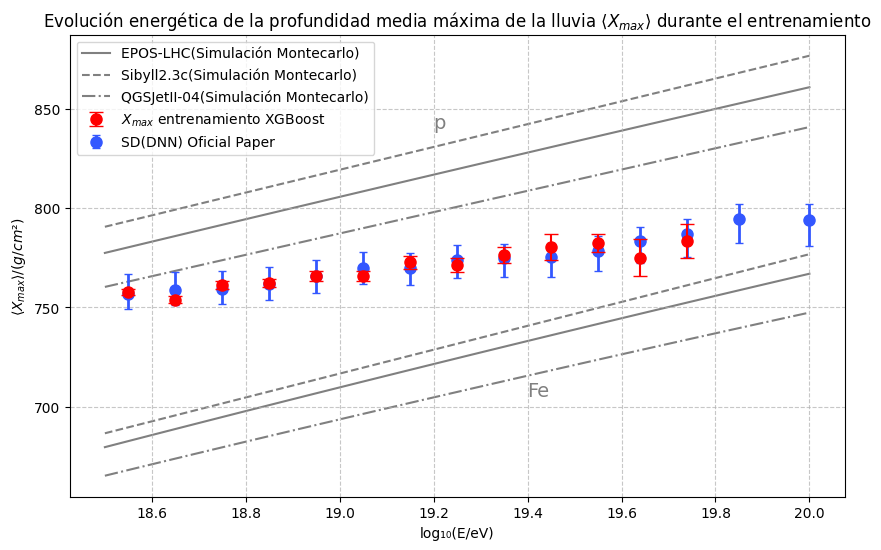

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Definir los puntos de energía específicos
energy_points = np.array([18.55, 18.65, 18.75, 18.85, 18.95, 19.05, 
                          19.15, 19.25, 19.35, 19.45, 19.55, 19.64, 
                          19.74, 19.85, 20.00])

# Inicializar listas para almacenar los valores de Xmax y SEM
mean_Xmax = []
sem_values = []

# Obtener los índices de y_test en data_filtered
test_indices = y_test.index  # Índices de y_test en data_filtered

# Calcular la media de Xmax y el SEM para cada intervalo de energía
for i in range(len(energy_points) - 1):
    lower_energy = energy_points[i]
    upper_energy = energy_points[i + 1]
    
    # Filtrar los datos en el intervalo de energía
    mask = (data_filtered.loc[test_indices, "log_CalEnergy"] >= lower_energy) & \
           (data_filtered.loc[test_indices, "log_CalEnergy"] < upper_energy)
    
    if mask.sum() > 5:  # Asegurar que haya suficientes datos
        y_true_interval = y_test[mask]
        mean_Xmax.append(np.mean(y_true_interval))
        sem = np.std(y_true_interval) / np.sqrt(mask.sum())  # Cálculo del SEM
        sem_values.append(sem)
    else:
        mean_Xmax.append(np.nan)  # Si no hay suficientes datos, asignar NaN
        sem_values.append(np.nan)

# Añadir el último punto (20.0)
mask = (data_filtered.loc[test_indices, "log_CalEnergy"] >= 19.85) & \
       (data_filtered.loc[test_indices, "log_CalEnergy"] <= 20.00)
if mask.sum() > 5:
    y_true_interval = y_test[mask]
    mean_Xmax.append(np.mean(y_true_interval))
    sem = np.std(y_true_interval) / np.sqrt(mask.sum())
    sem_values.append(sem)
else:
    mean_Xmax.append(np.nan)
    sem_values.append(np.nan)

# Convertir listas a arrays numpy para evitar errores al graficar
mean_Xmax = np.array(mean_Xmax)
sem_values = np.array(sem_values)

# Graficar Xmax vs Energía con barras de error de SEM
plt.figure(figsize=(10, 6))
plt.errorbar(energy_points, mean_Xmax, yerr=sem_values, fmt='o', color='red', 
             capsize=5, label='$X_{max}$ entrenamiento XGBoost', zorder=3, markersize=8)

plt.xlabel("log(Energía) [eV]")
plt.ylabel("Xmax [g/cm²]")
plt.title("Xmax vs log(Energía) con SEM como error estadístico")


# ================================
# 6. Obtención de modelos teóricos (ejemplo)
# ================================

def RailsFunc(lgE, p):
    return p[0] + p[1] * (lgE - 18.) + p[2] * (lgE - 18.) ** 2

def GetModelRails():
    return {
        'EPOS-LHC': {'H': {'mean': [748.78, 57.73, -0.85]}, 'Fe': {'mean': [648.60, 63.12, -1.97]}},
        'Sibyll2.3c': {'H': {'mean': [761.9, 57.4, -8.07e-10]}, 'Fe': {'mean': [656.6, 60.1, -0.00016]}},
        'QGSJetII-04': {'H': {'mean': [733.34, 54.05, -0.16]}, 'Fe': {'mean': [635.93, 59.70, -1.98]}}
    }
# Graficar modelos teóricos
lgE = np.linspace(18.5, 20, 100)
models = GetModelRails()
styles = {
    'EPOS-LHC': {'H': {'color': 'gray', 'linestyle': '-'}, 
                 'Fe': {'color': 'gray', 'linestyle': '-'}},
    'Sibyll2.3c': {'H': {'color': 'gray', 'linestyle': '--'}, 
                   'Fe': {'color': 'gray', 'linestyle': '--'}},
    'QGSJetII-04': {'H': {'color': 'gray', 'linestyle': '-.'}, 
                    'Fe': {'color': 'gray', 'linestyle': '-.'}}
}

for model, particles in models.items():
    for particle, params in particles.items():
        if model == 'Sibyll2.3c' and particle == 'H':
            label = '_nolegend_'
        elif model == 'EPOS-LHC' and particle == 'H':
            label = '_nolegend_'
        elif model == 'QGSJetII-04' and particle == 'H':
            label = '_nolegend_'
        else:
            label = model  # Se usa el nombre del modelo para la leyenda
        plt.plot(
            lgE, 
            RailsFunc(lgE, params['mean']), 
            color=styles[model][particle]['color'], 
            linestyle=styles[model][particle]['linestyle'],
            label=f"{label}(Simulación Montecarlo)",
            zorder=1
        )
plt.text(19.2, 840, "p", fontsize=14, color="gray")
plt.text(19.4, 705, "Fe", fontsize=14, color="gray")

# Agregar puntos específicos (por ejemplo, de otros estudios)
x_points = [18.55, 18.65, 18.75, 18.85, 18.95, 19.05, 19.15, 19.25, 19.35, 19.45, 19.55, 19.64, 19.74, 19.85, 20.00]
y_points = [757.0, 758.8, 759.5, 761.8, 765.7, 770.0, 769.9, 774.0, 774.7, 775.3, 778.6, 783.2, 787.2, 794.5, 793.9]

# Errores asimétricos para los puntos
y_error_asymmetric = [
    [7.7, 9.6], [7.8, 9.2], [7.9, 8.8], [8.0, 8.5], [8.2, 8.2],
    [8.4, 7.9], [8.7, 7.7], [9.1, 7.5], [9.5, 7.4], [10.0, 7.3],
    [10.5, 7.3], [11.0, 7.3], [11.6, 7.5], [12.2, 7.8], [13.1, 8.3]
]

plt.errorbar(
    x_points, y_points, 
    yerr=[np.array([lower for lower, upper in y_error_asymmetric]),
          np.array([upper for lower, upper in y_error_asymmetric])],
    fmt='o', color='#3357FF', ecolor='#3357FF', elinewidth=2, capsize=3,
    label="SD(DNN) Oficial Paper", markersize=8, zorder=2
)

# Configuración adicional de la gráfica
plt.xlabel('log₁₀(E/eV)')
plt.ylabel('$⟨X_{max}⟩ / (g/cm²)$')
plt.title('Evolución energética de la profundidad media máxima de la lluvia $⟨X_{max}⟩$ durante el entrenamiento')

plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


Número de eventos en cada intervalo de energía:
Energy_Bin
(18.55, 18.650000000000002]                 6052
(18.650000000000002, 18.750000000000004]    3985
(18.750000000000004, 18.850000000000005]    3211
(18.850000000000005, 18.950000000000006]    2267
(18.950000000000006, 19.050000000000008]    1818
(19.050000000000008, 19.15000000000001]     1312
(19.15000000000001, 19.25000000000001]       902
(19.25000000000001, 19.350000000000012]      607
(19.350000000000012, 19.450000000000014]     442
(19.450000000000014, 19.550000000000015]     250
(19.550000000000015, 19.650000000000016]     141
(19.650000000000016, 19.750000000000018]      72
(19.750000000000018, 19.85000000000002]       29
(19.85000000000002, 19.95000000000002]        10
(19.95000000000002, 20.050000000000022]        0
Name: count, dtype: int64


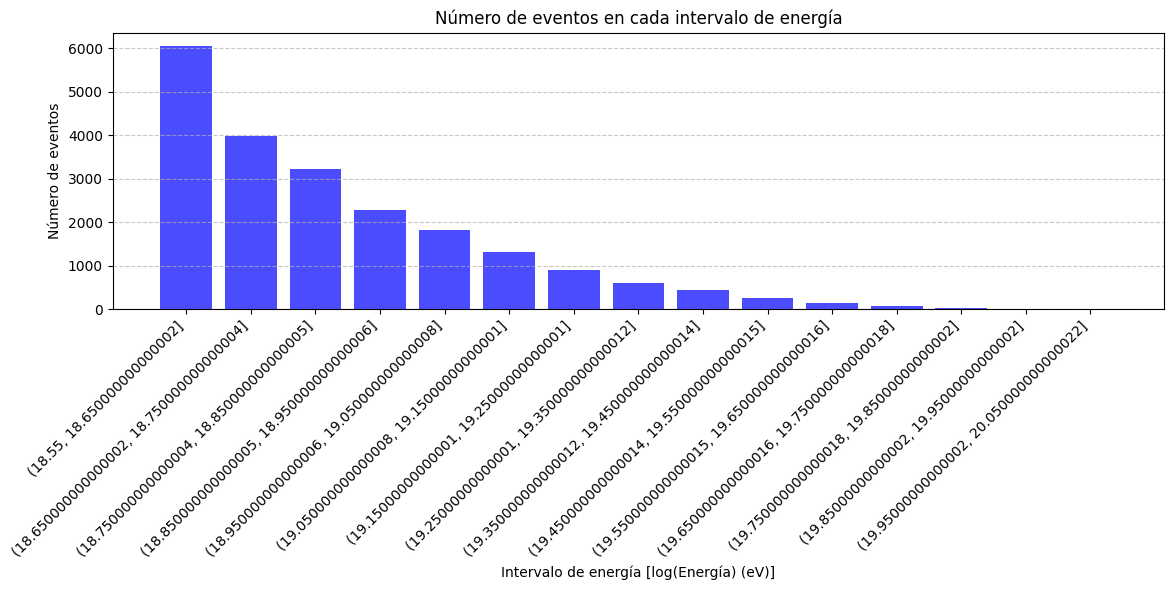

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Definir los puntos de energía específicos
energy_points = np.array([18.55, 18.65, 18.75, 18.85, 18.95, 19.05, 
                          19.15, 19.25, 19.35, 19.45, 19.55, 19.64, 
                          19.74, 19.85, 20.00, 20.10])

# Crear bins a partir de los puntos de energía
bins = pd.interval_range(start=energy_points.min(), end=energy_points.max(), freq=0.1, closed='right')

# Asignar cada evento a un bin
data_filtered["Energy_Bin"] = pd.cut(data_filtered["log_CalEnergy"], bins=bins)

# Contar el número de eventos en cada bin
event_counts = data_filtered["Energy_Bin"].value_counts().sort_index()

# Mostrar el número de eventos en cada intervalo
print("Número de eventos en cada intervalo de energía:")
print(event_counts)

# Graficar el número de eventos en cada intervalo de energía
plt.figure(figsize=(12, 6))
plt.bar(event_counts.index.astype(str), event_counts.values, color='blue', alpha=0.7)

# Personalizar la gráfica
plt.xlabel("Intervalo de energía [log(Energía) (eV)]")
plt.ylabel("Número de eventos")
plt.title("Número de eventos en cada intervalo de energía")
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje x para mejor legibilidad
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar la gráfica
plt.tight_layout()
plt.show()

Número de eventos en cada intervalo de energía:
Energy_Bin
(18.5, 18.6]                                6981
(18.6, 18.700000000000003]                  4967
(18.700000000000003, 18.800000000000004]    3516
(18.800000000000004, 18.900000000000006]    2788
(18.900000000000006, 19.000000000000007]    2014
(19.000000000000007, 19.10000000000001]     1529
(19.10000000000001, 19.20000000000001]      1112
(19.20000000000001, 19.30000000000001]       702
(19.30000000000001, 19.400000000000013]      543
(19.400000000000013, 19.500000000000014]     349
(19.500000000000014, 19.600000000000016]     207
(19.600000000000016, 19.700000000000017]      74
(19.700000000000017, 19.80000000000002]       52
(19.80000000000002, 19.90000000000002]        20
(19.90000000000002, 20.00000000000002]         4
(20.00000000000002, 20.100000000000023]        0
Name: count, dtype: int64


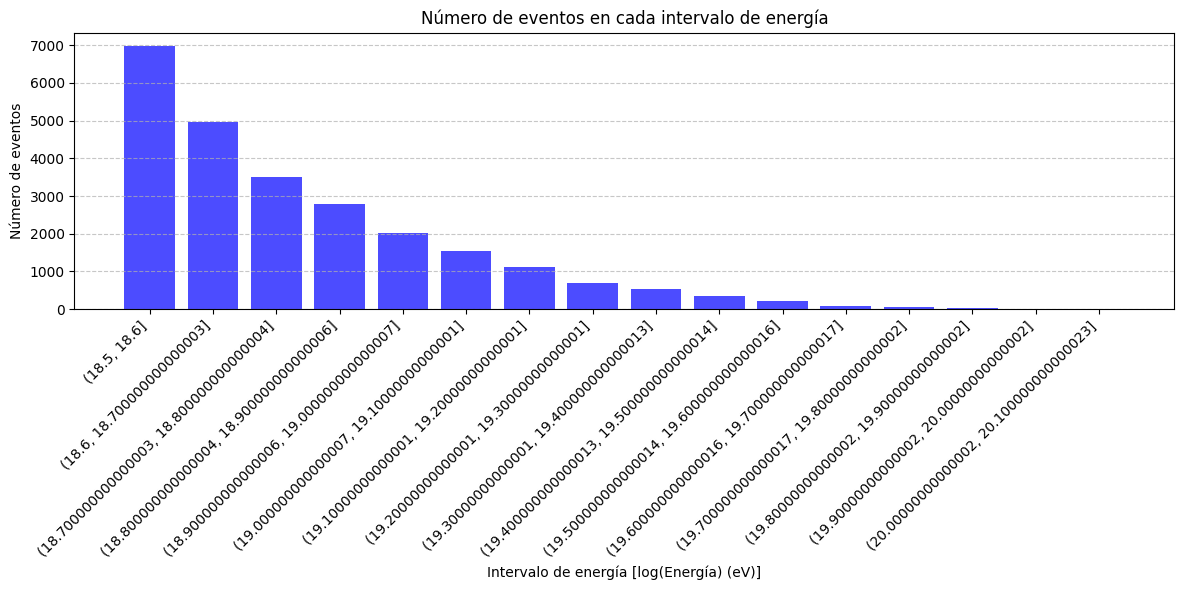

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Definir los puntos de energía específicos
energy_points = np.array([18.5, 18.6, 18.7, 18.8, 18.9, 19.0, 
                          19.1, 19.2, 19.3, 19.4, 19.5, 19.6, 
                          19.7, 19.8, 19.9, 20.00, 20.1])

# Crear bins a partir de los puntos de energía
bins = pd.interval_range(start=energy_points.min(), end=energy_points.max(), freq=0.1, closed='right')

# Asignar cada evento a un bin
data_filtered["Energy_Bin"] = pd.cut(data_filtered["log_CalEnergy"], bins=bins)

# Contar el número de eventos en cada bin
event_counts = data_filtered["Energy_Bin"].value_counts().sort_index()

# Mostrar el número de eventos en cada intervalo
print("Número de eventos en cada intervalo de energía:")
print(event_counts)

# Graficar el número de eventos en cada intervalo de energía
plt.figure(figsize=(12, 6))
plt.bar(event_counts.index.astype(str), event_counts.values, color='blue', alpha=0.7)

# Personalizar la gráfica
plt.xlabel("Intervalo de energía [log(Energía) (eV)]")
plt.ylabel("Número de eventos")
plt.title("Número de eventos en cada intervalo de energía")
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje x para mejor legibilidad
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar la gráfica
plt.tight_layout()
plt.show()

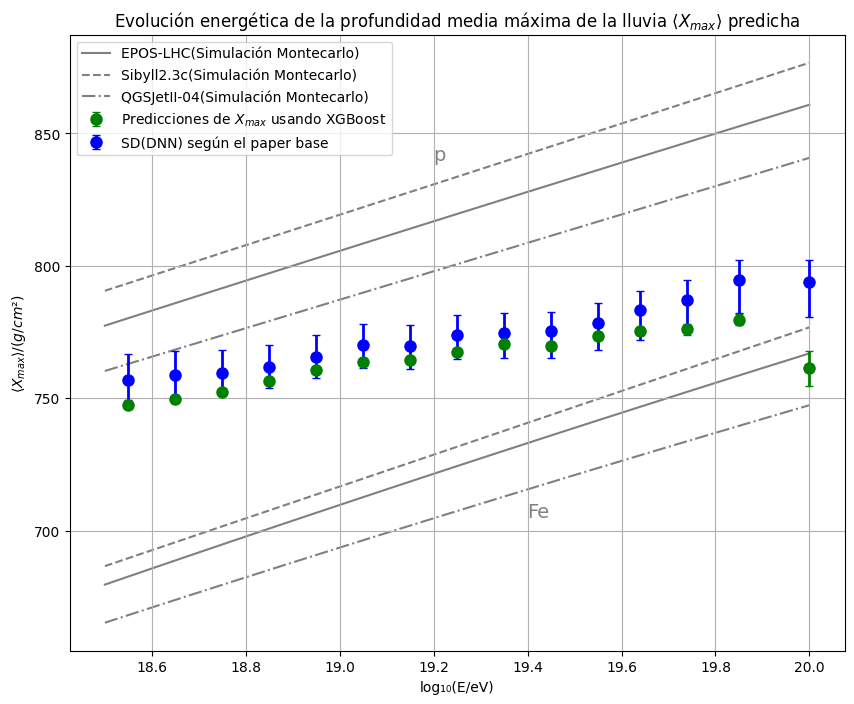

Tiempo de ejecución: 33.70 segundos


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
import joblib
import time

# Registrar el tiempo de inicio
start_time = time.time()

# ================================
# 1. Carga y preprocesamiento de datos
# ================================
# Cargar datos originales
dfFD = pd.read_csv("FD_num.csv", sep="\t")
dfSD = pd.read_csv("SD_num.csv", sep="\t")

# Definir las columnas de interés
fd_columns = ["FD_RS_fXmax", "FD_RS_fEnergy"]
sd_columns = dfSD.columns

# Combinar datos de FD y SD
data = pd.merge(dfFD[fd_columns], dfSD[sd_columns], left_index=True, right_index=True)
data.fillna(data.median(), inplace=True)

# Filtrar datos en el rango de energía y calcular el logaritmo de la energía
data_filtered = data[(data["FD_RS_fEnergy"] >= 10**18.5) & (data["FD_RS_fEnergy"] <= 10**20)].copy()
data_filtered["log_CalEnergy"] = np.log10(data_filtered["FD_RS_fEnergy"])

# ================================
# 2. Cargar el modelo XGBoost y el escalador
# ================================
scaler_X = joblib.load('scalerXGBSD_6.pkl')
xgb_model = xgb.Booster()
xgb_model.load_model('xgbmSD_6.model')

# ================================
# 3. Predicción en nuevos datos de SD
# ================================
dfSD_nuevo = pd.read_csv("SDnewversion.csv")

# Filtrar datos de energía en la nueva base
dfSD_nuevo = dfSD_nuevo[(dfSD_nuevo["SD_RS_fEnergy"] >= 10**18.5) & 
                        (dfSD_nuevo["SD_RS_fEnergy"] <= 10**20)].copy()

# Crear DataFrame con las columnas utilizadas en el modelo
new_data = pd.DataFrame()
for col in sd_columns:
    new_data[col] = dfSD_nuevo[col]

# Crear características derivadas
new_data["log_CalEnergy"] = np.log10(new_data["SD_RS_fEnergy"])

# Asegurar el orden correcto de las características
feature_columns = data_filtered.drop(columns=["FD_RS_fXmax", "FD_RS_fEnergy"]).columns
new_data = new_data[feature_columns]

# Normalizar los datos
X_SD_nuevo_scaled = scaler_X.transform(new_data)

# Crear DMatrix y predecir con XGBoost
dmatrix_nuevo = xgb.DMatrix(X_SD_nuevo_scaled)
y_pred_SD_nuevo = xgb_model.predict(dmatrix_nuevo)

# Agregar predicciones al DataFrame
new_data["Pred_FD_RS_fXmax"] = y_pred_SD_nuevo

# ================================
# 4. Calcular SEM para cada punto de energía
# ================================
# Definir los puntos de energía específicos
energy_points = np.array([18.55, 18.65, 18.75, 18.85, 18.95, 19.05, 
                          19.15, 19.25, 19.35, 19.45, 19.55, 19.64, 
                          19.74, 19.85, 20.00])

# Inicializar listas para almacenar los valores de Xmax y SEM
xmax_points = []
sem_points = []

# Calcular la media y el SEM para cada intervalo de energía
for i in range(len(energy_points)):
    # Filtrar los datos en el intervalo de energía
    mask = (new_data["log_CalEnergy"] >= energy_points[i] - 0.05) & \
           (new_data["log_CalEnergy"] < energy_points[i] + 0.05)
    
    if mask.sum() > 0:  # Asegurar que haya datos en el intervalo
        xmax_mean = np.mean(new_data.loc[mask, "Pred_FD_RS_fXmax"])
        xmax_std = np.std(new_data.loc[mask, "Pred_FD_RS_fXmax"])
        sem = xmax_std / np.sqrt(mask.sum())  # Calcular SEM
        xmax_points.append(xmax_mean)
        sem_points.append(sem)
    else:
        xmax_points.append(np.nan)  # Si no hay datos, asignar NaN
        sem_points.append(np.nan)

# ================================
# 5. Gráfica de resultados con SEM
# ================================
plt.figure(figsize=(10, 8))
plt.errorbar(energy_points, xmax_points, yerr=sem_points, color="green", ecolor='green', elinewidth=2, markersize=8, zorder=3, capsize=3, fmt='o', label='Predicciones de $X_{max}$ usando XGBoost ')
plt.xlabel('log₁₀(E/eV)')
plt.ylabel('$⟨X_{max}⟩ / (g/cm²)$')
plt.title('Evolución energética de la profundidad media máxima de la lluvia $⟨X_{max}⟩$ predicha')

# Agregar puntos específicos (por ejemplo, de otros estudios)
x_points = [18.55, 18.65, 18.75, 18.85, 18.95, 19.05, 19.15, 19.25, 19.35, 19.45, 19.55, 19.64, 19.74, 19.85, 20.00]
y_points = [757.0, 758.8, 759.5, 761.8, 765.7, 770.0, 769.9, 774.0, 774.7, 775.3, 778.6, 783.2, 787.2, 794.5, 793.9]

# Errores asimétricos para los puntos
y_error_asymmetric = [
    [7.7, 9.6], [7.8, 9.2], [7.9, 8.8], [8.0, 8.5], [8.2, 8.2],
    [8.4, 7.9], [8.7, 7.7], [9.1, 7.5], [9.5, 7.4], [10.0, 7.3],
    [10.5, 7.3], [11.0, 7.3], [11.6, 7.5], [12.2, 7.8], [13.1, 8.3]
]

plt.errorbar(
    x_points, y_points, 
    yerr=[np.array([lower for lower, upper in y_error_asymmetric]),
          np.array([upper for lower, upper in y_error_asymmetric])],
    fmt='o', color='blue', ecolor='blue', elinewidth=2, capsize=3,
    label="SD(DNN) según el paper base", markersize=8, zorder=2
)


def RailsFunc(lgE, p):
    return p[0] + p[1] * (lgE - 18.) + p[2] * (lgE - 18.) ** 2

def GetModelRails():
    return {
        'EPOS-LHC': {'H': {'mean': [748.78, 57.73, -0.85]}, 'Fe': {'mean': [648.60, 63.12, -1.97]}},
        'Sibyll2.3c': {'H': {'mean': [761.9, 57.4, -8.07e-10]}, 'Fe': {'mean': [656.6, 60.1, -0.00016]}},
        'QGSJetII-04': {'H': {'mean': [733.34, 54.05, -0.16]}, 'Fe': {'mean': [635.93, 59.70, -1.98]}}
    }
# Graficar modelos teóricos
lgE = np.linspace(18.5, 20, 100)
models = GetModelRails()
styles = {
    'EPOS-LHC': {'H': {'color': 'gray', 'linestyle': '-'}, 
                 'Fe': {'color': 'gray', 'linestyle': '-'}},
    'Sibyll2.3c': {'H': {'color': 'gray', 'linestyle': '--'}, 
                   'Fe': {'color': 'gray', 'linestyle': '--'}},
    'QGSJetII-04': {'H': {'color': 'gray', 'linestyle': '-.'}, 
                    'Fe': {'color': 'gray', 'linestyle': '-.'}}
}

for model, particles in models.items():
    for particle, params in particles.items():
        if model == 'Sibyll2.3c' and particle == 'H':
            label = '_nolegend_'
        elif model == 'EPOS-LHC' and particle == 'H':
            label = '_nolegend_'
        elif model == 'QGSJetII-04' and particle == 'H':
            label = '_nolegend_'
        else:
            label = model  # Se usa el nombre del modelo para la leyenda
        plt.plot(
            lgE, 
            RailsFunc(lgE, params['mean']), 
            color=styles[model][particle]['color'], 
            linestyle=styles[model][particle]['linestyle'],
            label=f"{label}(Simulación Montecarlo)",
            zorder=1
        )
plt.text(19.2, 840, "p", fontsize=14, color="gray")
plt.text(19.4, 705, "Fe", fontsize=14, color="gray")



plt.legend()
plt.grid()
plt.show()

# Tiempo de ejecución
time_elapsed = time.time() - start_time
print(f"Tiempo de ejecución: {time_elapsed:.2f} segundos")

In [20]:
sem_points

[np.float64(0.17117405290466353),
 np.float64(0.21796618915252855),
 np.float64(0.27510003816698525),
 np.float64(0.3396507755989097),
 np.float64(0.39043731819648037),
 np.float64(0.46770072644282723),
 np.float64(0.5459362126103676),
 np.float64(0.6184619627349879),
 np.float64(0.754111314154544),
 np.float64(0.9252623358829271),
 np.float64(1.1023690169176885),
 np.float64(1.6347720536004313),
 np.float64(2.0847766186185113),
 np.float64(2.1684394412355),
 np.float64(6.67510986328125)]

In [22]:
xmax_points

[np.float32(747.4882),
 np.float32(749.6572),
 np.float32(752.2665),
 np.float32(756.68085),
 np.float32(760.51965),
 np.float32(763.8313),
 np.float32(764.4756),
 np.float32(767.36505),
 np.float32(770.5028),
 np.float32(769.66986),
 np.float32(773.50006),
 np.float32(775.45685),
 np.float32(776.0701),
 np.float32(779.7084),
 np.float32(761.29895)]

In [21]:
import numpy as np

# Valores de energía (log(E))
energia = np.array([18.55, 18.65, 18.75, 18.85, 18.95, 19.05, 19.15, 
                    19.25, 19.35, 19.45, 19.55, 19.64, 19.74])

# Xmax para el primer conjunto de datos
xmax_1 = np.array([757.82, 753.85, 761.41, 762.34, 765.87, 765.85, 772.63, 
                    771.57, 776.37, 780.20, 782.59, 775.05, 783.35])

# Xmax para el segundo conjunto de datos
xmax_2 = np.array([747.4882, 749.6572, 752.2665, 756.68085, 760.51965, 763.8313, 764.4756, 
                    767.36505, 770.5028, 769.66986, 773.50006, 775.45685, 776.0701])

# Calcular delta Xmax
delta_xmax = np.abs(xmax_1 - xmax_2)

# Calcular el promedio de delta Xmax
delta_xmax_promedio = np.mean(delta_xmax)
delta_xmax_promedio

np.float64(6.325360000000037)

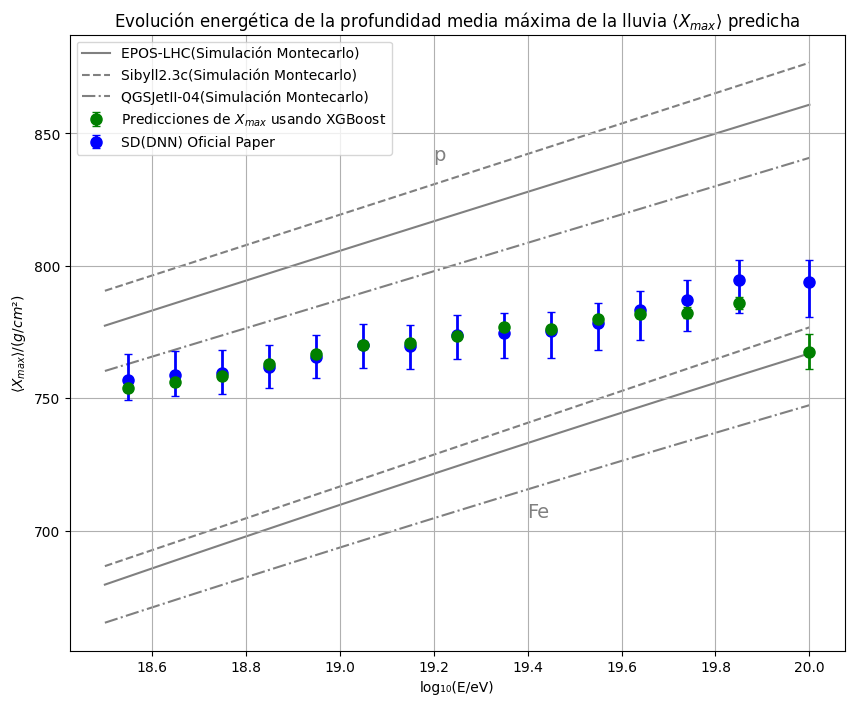

Tiempo de ejecución: 34.49 segundos


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
import joblib
import time

# Registrar el tiempo de inicio
start_time = time.time()

# ================================
# 1. Carga y preprocesamiento de datos
# ================================
# Cargar datos originales
dfFD = pd.read_csv("FD_num.csv", sep="\t")
dfSD = pd.read_csv("SD_num.csv", sep="\t")

# Definir las columnas de interés
fd_columns = ["FD_RS_fXmax", "FD_RS_fEnergy"]
sd_columns = dfSD.columns

# Combinar datos de FD y SD
data = pd.merge(dfFD[fd_columns], dfSD[sd_columns], left_index=True, right_index=True)
data.fillna(data.median(), inplace=True)

# Filtrar datos en el rango de energía y calcular el logaritmo de la energía
data_filtered = data[(data["FD_RS_fEnergy"] >= 10**18.5) & (data["FD_RS_fEnergy"] <= 10**20)].copy()
data_filtered["log_CalEnergy"] = np.log10(data_filtered["FD_RS_fEnergy"])

# ================================
# 2. Cargar el modelo XGBoost y el escalador
# ================================
scaler_X = joblib.load('scalerXGBSD_6.pkl')
xgb_model = xgb.Booster()
xgb_model.load_model('xgbmSD_6.model')

# ================================
# 3. Predicción en nuevos datos de SD
# ================================
dfSD_nuevo = pd.read_csv("SDnewversion.csv")

# Filtrar datos de energía en la nueva base
dfSD_nuevo = dfSD_nuevo[(dfSD_nuevo["SD_RS_fEnergy"] >= 10**18.5) & 
                        (dfSD_nuevo["SD_RS_fEnergy"] <= 10**20)].copy()

# Crear DataFrame con las columnas utilizadas en el modelo
new_data = pd.DataFrame()
for col in sd_columns:
    new_data[col] = dfSD_nuevo[col]

# Crear características derivadas
new_data["log_CalEnergy"] = np.log10(new_data["SD_RS_fEnergy"])

# Asegurar el orden correcto de las características
feature_columns = data_filtered.drop(columns=["FD_RS_fXmax", "FD_RS_fEnergy"]).columns
new_data = new_data[feature_columns]

# Normalizar los datos
X_SD_nuevo_scaled = scaler_X.transform(new_data)

# Crear DMatrix y predecir con XGBoost
dmatrix_nuevo = xgb.DMatrix(X_SD_nuevo_scaled)
y_pred_SD_nuevo = xgb_model.predict(dmatrix_nuevo)

# Agregar predicciones al DataFrame
new_data["Pred_FD_RS_fXmax"] = y_pred_SD_nuevo

# ================================
# 4. Calcular SEM para cada punto de energía
# ================================
# Definir los puntos de energía específicos
energy_points = np.array([18.55, 18.65, 18.75, 18.85, 18.95, 19.05, 
                          19.15, 19.25, 19.35, 19.45, 19.55, 19.64, 
                          19.74, 19.85, 20.00])

# Inicializar listas para almacenar los valores de Xmax y SEM
xmax_points = []
sem_points = []

# Calcular la media y el SEM para cada intervalo de energía
for i in range(len(energy_points)):
    # Filtrar los datos en el intervalo de energía
    mask = (new_data["log_CalEnergy"] >= energy_points[i] - 0.05) & \
           (new_data["log_CalEnergy"] < energy_points[i] + 0.05)
    
    if mask.sum() > 0:  # Asegurar que haya datos en el intervalo
        xmax_mean = np.mean(new_data.loc[mask, "Pred_FD_RS_fXmax"])
        xmax_std = np.std(new_data.loc[mask, "Pred_FD_RS_fXmax"])
        sem = xmax_std / np.sqrt(mask.sum())  # Calcular SEM
        xmax_points.append(xmax_mean)
        sem_points.append(sem)
    else:
        xmax_points.append(np.nan)  # Si no hay datos, asignar NaN
        sem_points.append(np.nan)
# Convertir xmax_points a un array de NumPy
xmax_points = np.array(xmax_points)

# Sumar el valor a todos los elementos del array
valor_a_sumar = 6.32536
xmax_points_ajustados = xmax_points + valor_a_sumar

# ================================
# 5. Gráfica de resultados con SEM
# ================================
plt.figure(figsize=(10, 8))
plt.errorbar(energy_points, xmax_points_ajustados, yerr=sem_points, color="green", ecolor='green', elinewidth=2, markersize=8, zorder=3, capsize=3, fmt='o', label='Predicciones de $X_{max}$ usando XGBoost ')
plt.xlabel('log₁₀(E/eV)')
plt.ylabel('$⟨X_{max}⟩ / (g/cm²)$')
plt.title('Evolución energética de la profundidad media máxima de la lluvia $⟨X_{max}⟩$ predicha')

# Agregar puntos específicos (por ejemplo, de otros estudios)
x_points = [18.55, 18.65, 18.75, 18.85, 18.95, 19.05, 19.15, 19.25, 19.35, 19.45, 19.55, 19.64, 19.74, 19.85, 20.00]
y_points = [757.0, 758.8, 759.5, 761.8, 765.7, 770.0, 769.9, 774.0, 774.7, 775.3, 778.6, 783.2, 787.2, 794.5, 793.9]

# Errores asimétricos para los puntos
y_error_asymmetric = [
    [7.7, 9.6], [7.8, 9.2], [7.9, 8.8], [8.0, 8.5], [8.2, 8.2],
    [8.4, 7.9], [8.7, 7.7], [9.1, 7.5], [9.5, 7.4], [10.0, 7.3],
    [10.5, 7.3], [11.0, 7.3], [11.6, 7.5], [12.2, 7.8], [13.1, 8.3]
]

plt.errorbar(
    x_points, y_points, 
    yerr=[np.array([lower for lower, upper in y_error_asymmetric]),
          np.array([upper for lower, upper in y_error_asymmetric])],
    fmt='o', color='blue', ecolor='blue', elinewidth=2, capsize=3,
    label="SD(DNN) Oficial Paper", markersize=8, zorder=2
)


def RailsFunc(lgE, p):
    return p[0] + p[1] * (lgE - 18.) + p[2] * (lgE - 18.) ** 2

def GetModelRails():
    return {
        'EPOS-LHC': {'H': {'mean': [748.78, 57.73, -0.85]}, 'Fe': {'mean': [648.60, 63.12, -1.97]}},
        'Sibyll2.3c': {'H': {'mean': [761.9, 57.4, -8.07e-10]}, 'Fe': {'mean': [656.6, 60.1, -0.00016]}},
        'QGSJetII-04': {'H': {'mean': [733.34, 54.05, -0.16]}, 'Fe': {'mean': [635.93, 59.70, -1.98]}}
    }
# Graficar modelos teóricos
lgE = np.linspace(18.5, 20, 100)
models = GetModelRails()
styles = {
    'EPOS-LHC': {'H': {'color': 'gray', 'linestyle': '-'}, 
                 'Fe': {'color': 'gray', 'linestyle': '-'}},
    'Sibyll2.3c': {'H': {'color': 'gray', 'linestyle': '--'}, 
                   'Fe': {'color': 'gray', 'linestyle': '--'}},
    'QGSJetII-04': {'H': {'color': 'gray', 'linestyle': '-.'}, 
                    'Fe': {'color': 'gray', 'linestyle': '-.'}}
}

for model, particles in models.items():
    for particle, params in particles.items():
        if model == 'Sibyll2.3c' and particle == 'H':
            label = '_nolegend_'
        elif model == 'EPOS-LHC' and particle == 'H':
            label = '_nolegend_'
        elif model == 'QGSJetII-04' and particle == 'H':
            label = '_nolegend_'
        else:
            label = model  # Se usa el nombre del modelo para la leyenda
        plt.plot(
            lgE, 
            RailsFunc(lgE, params['mean']), 
            color=styles[model][particle]['color'], 
            linestyle=styles[model][particle]['linestyle'],
            label=f"{label}(Simulación Montecarlo)",
            zorder=1
        )
plt.text(19.2, 840, "p", fontsize=14, color="gray")
plt.text(19.4, 705, "Fe", fontsize=14, color="gray")



plt.legend()
plt.grid()
plt.show()

# Tiempo de ejecución
time_elapsed = time.time() - start_time
print(f"Tiempo de ejecución: {time_elapsed:.2f} segundos")

In [29]:
# Definir los puntos de energía específicos
energy_points = np.array([18.55, 18.65, 18.75, 18.85, 18.95, 19.05, 
                          19.15, 19.25, 19.35, 19.45, 19.55, 19.64, 
                          19.74, 19.85, 20.00])

# Crear bins a partir de los puntos de energía
bins = pd.interval_range(start=energy_points.min(), end=energy_points.max(), freq=0.1, closed='right')

# Asignar cada evento a un bin
new_data["Energy_Bin"] = pd.cut(new_data["log_CalEnergy"], bins=bins)

# Contar el número de eventos en cada bin
event_counts = new_data["Energy_Bin"].value_counts().sort_index()

# Mostrar el número de eventos en cada intervalo
print("Número de eventos en cada intervalo de energía:")
print(event_counts)

Número de eventos en cada intervalo de energía:
Energy_Bin
(18.55, 18.650000000000002]                 18971
(18.650000000000002, 18.750000000000004]    11639
(18.750000000000004, 18.850000000000005]     7647
(18.850000000000005, 18.950000000000006]     5250
(18.950000000000006, 19.050000000000008]     3739
(19.050000000000008, 19.15000000000001]      2603
(19.15000000000001, 19.25000000000001]       1659
(19.25000000000001, 19.350000000000012]      1102
(19.350000000000012, 19.450000000000014]      675
(19.450000000000014, 19.550000000000015]      445
(19.550000000000015, 19.650000000000016]      264
(19.650000000000016, 19.750000000000018]       97
(19.750000000000018, 19.85000000000002]        61
(19.85000000000002, 19.95000000000002]         26
Name: count, dtype: int64


In [23]:
# Definir los puntos de energía específicos
energy_points = np.array([18.5, 18.6, 18.7, 18.8, 18.9, 19.0, 
                          19.1, 19.2, 19.3, 19.4, 19.5, 19.6, 
                          19.7, 19.8, 19.9, 20.00, 20.1])

# Crear bins a partir de los puntos de energía
bins = pd.interval_range(start=energy_points.min(), end=energy_points.max(), freq=0.1, closed='right')

# Asignar cada evento a un bin
new_data["Energy_Bin"] = pd.cut(new_data["log_CalEnergy"], bins=bins)

# Contar el número de eventos en cada bin
event_counts = new_data["Energy_Bin"].value_counts().sort_index()

# Mostrar el número de eventos en cada intervalo
print("Número de eventos en cada intervalo de energía:")
print(event_counts)

Número de eventos en cada intervalo de energía:
Energy_Bin
(18.5, 18.6]                                24347
(18.6, 18.700000000000003]                  14835
(18.700000000000003, 18.800000000000004]     9329
(18.800000000000004, 18.900000000000006]     6361
(18.900000000000006, 19.000000000000007]     4442
(19.000000000000007, 19.10000000000001]      3099
(19.10000000000001, 19.20000000000001]       2073
(19.20000000000001, 19.30000000000001]       1379
(19.30000000000001, 19.400000000000013]       898
(19.400000000000013, 19.500000000000014]      514
(19.500000000000014, 19.600000000000016]      346
(19.600000000000016, 19.700000000000017]      180
(19.700000000000017, 19.80000000000002]        69
(19.80000000000002, 19.90000000000002]         50
(19.90000000000002, 20.00000000000002]          9
(20.00000000000002, 20.100000000000023]         0
Name: count, dtype: int64


In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost as xgb
import matplotlib.pyplot as plt
import joblib

# Cargar datos
dfFD = pd.read_csv("dataSummarySD1500.csv")
dfFD.columns

Index(['id', 'sdid', 'gpstime', 'sd1500', 'multiEye', 'sd_gpsnanotime',
       'sd_theta', 'sd_dtheta', 'sd_phi', 'sd_dphi', 'sd_energy', 'sd_denergy',
       'sd_l', 'sd_b', 'sd_ra', 'sd_dec', 'sd_x', 'sd_dx', 'sd_y', 'sd_dy',
       'sd_z', 'sd_easting', 'sd_northing', 'sd_altitude', 'sd_R', 'sd_dR',
       'sd_s1000', 'sd_ds1000', 'sd_s38', 'sd_gcorr', 'sd_wcorr', 'sd_beta',
       'sd_gamma', 'sd_chi2', 'sd_ndf', 'sd_geochi2', 'sd_geondf', 'sd_nbstat',
       'fd_id', 'fd_gpsnanotime', 'fd_hdSpectrumEye', 'fd_hdCalibEye',
       'fd_hdXmaxEye', 'fd_theta', 'fd_dtheta', 'fd_phi', 'fd_dphi', 'fd_l',
       'fd_b', 'fd_ra', 'fd_dec', 'fd_totalEnergy', 'fd_dtotalEnergy',
       'fd_calEnergy', 'fd_dcalEnergy', 'fd_xmax', 'fd_dxmax', 'fd_heightXmax',
       'fd_distXmax', 'fd_dEdXmax', 'fd_ddEdXmax', 'fd_x', 'fd_dx', 'fd_y',
       'fd_dy', 'fd_z', 'fd_easting', 'fd_northing', 'fd_altitude',
       'fd_cherenkovFraction', 'fd_minViewAngle', 'fd_uspL', 'fd_duspL',
       'fd_uspR', 'fd_d

In [43]:
fd_columns = ["fd_totalEnergy", "fd_dxmax"]
dfFD[fd_columns]

,fd_totalEnergy,fd_dxmax
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
24314,NaN,NaN
24315,NaN,NaN
24316,NaN,NaN
24317,NaN,NaN
